In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.plotsettings import *
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

%matplotlib inline

## Load results


In [3]:
all_out = glob("out/**/*.pkl")

In [4]:
all_out = [load_pickle(p) for p in all_out]

In [5]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out:
    try:
        res = {
            "train_size": out["train_size"],
            "frac_valid": out["frac_valid"],
            "accuracy": out["accuracy"],
            "f1_macro": out["f1_macro"],
            "f1_micro": out["f1_micro"],
            "kappa": out["kappa"],
            "num_classes": out["num_classes"],
            "target": out["target"],
        }
        extracted_res.append(res)
    except KeyError:
        pass

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["baseline"]["xgb_metrics"]["accuracy"],
        "f1_macro": out["baseline"]["xgb_metrics"]["f1_macro"],
        "f1_micro": out["baseline"]["xgb_metrics"]["f1_micro"],
        "kappa": out["baseline"]["xgb_metrics"]["kappa"],
        "num_classes": out["num_classes"],
        "target": out["target"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["baseline"]["tabpfn_metrics"]["accuracy"],
        "f1_macro": out["baseline"]["tabpfn_metrics"]["f1_macro"],
        "f1_micro": out["baseline"]["tabpfn_metrics"]["f1_micro"],
        "kappa": out["baseline"]["tabpfn_metrics"]["kappa"],
        "num_classes": out["num_classes"],
        "target": out["target"],
    }

    xgboost_results.append(xgb_res)
    if out["baseline"]["tabpfn_metrics"]["accuracy"] > 0:
        tabpfn_results.append(tabpfn_res)

In [6]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [7]:
res

,train_size,frac_valid,accuracy,f1_macro,f1_micro,kappa,num_classes,target
0,10,1.0,0.228,0.155294,0.228,0.035,5,"(logKH_CH4, CH4 Henry coefficient)"
1,20,0.0,0.000,0.000000,0.000,0.000,5,"(logKH_CH4, CH4 Henry coefficient)"
2,20,1.0,0.508,0.507614,0.508,0.016,2,"(logKH_CH4, CH4 Henry coefficient)"
3,100,1.0,0.320,0.312925,0.320,0.150,5,"(logKH_CH4, CH4 Henry coefficient)"
4,100,1.0,0.568,0.567557,0.568,0.136,2,"(logKH_CH4, CH4 Henry coefficient)"
...,...,...,...,...,...,...,...,...
83,10,1.0,0.472,0.467879,0.472,-0.056,2,"(logKH_CH4, CH4 Henry coefficient)"
84,20,1.0,0.200,0.184236,0.200,0.000,5,"(logKH_CO2, CO2 Henry coefficient)"
85,20,1.0,0.488,0.486389,0.488,-0.024,2,"(logKH_CO2, CO2 Henry coefficient)"
86,200,1.0,0.316,0.310068,0.316,0.145,5,"(logKH_CH4, CH4 Henry coefficient)"


In [8]:
grouped_res = res.groupby(["num_classes", "target", "train_size"]).agg(["mean", "std", sem])

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

In [9]:
grouped_xgboost_res = xgboost_res.groupby(["num_classes", "target", "train_size"]).agg(
    ["mean", "std", sem]
)

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

In [10]:
grouped_tabpfn_res = tabpfn_res.groupby(["num_classes", "target", "train_size"]).agg(
    ["mean", "std", sem]
)

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

In [11]:
grouped_res.loc[2, :]

frac_valid                      \
                                                    mean       std       sem   
target                             train_size                                  
(logKH_CH4, CH4 Henry coefficient) 10           0.777778  0.440959  0.146986   
                                   20           0.666667  0.516398  0.210819   
                                   50           0.800000  0.447214  0.200000   
                                   100          1.000000  0.000000  0.000000   
                                   200          1.000000  0.000000  0.000000   
                                   500          1.000000  0.000000  0.000000   
(logKH_CO2, CO2 Henry coefficient) 10           0.777778  0.440959  0.146986   
                                   20           0.666667  0.516398  0.210819   
                                   50           0.750000  0.500000  0.250000   
                                   100          1.000000  0.000000  0.000000   
                                   200          1.000000  0.000000  0.000000   
                                   500          1.000000       NaN       NaN   

                                               accuracy                      \
                                                   mean       std       sem   
target                             train_size                                 
(logKH_CH4, CH4 Henry coefficient) 10          0.411111  0.235421  0.078474   
                                   20          0.364667  0.283943  0.115919   
                                   50          0.448000  0.252159  0.112769   
                                   100         0.568000  0.008000  0.004619   
                                   200         0.526667  0.048881  0.028221   
                                   500         0.602000  0.031113  0.022000   
(logKH_CO2, CO2 Henry coefficient) 10          0.401778  0.229862  0.076621   
                                   20          0.343333  0.266418  0.108765   
                                   50          0.411000  0.274603  0.137301   
                                   100         0.548000  0.067882  0.048000   
                                   200         0.574000  0.008485  0.006000   
                                   500         0.644000       NaN       NaN   

                                               f1_macro                      \
                                                   mean       std       sem   
target                             train_size                                 
(logKH_CH4, CH4 Henry coefficient) 10          0.380077  0.225056  0.075019   
                                   20          0.360733  0.280502  0.114514   
                                   50          0.447084  0.251672  0.112551   
                                   100         0.566699  0.009732  0.005619   
                                   200         0.524704  0.050623  0.029227   
                                   500         0.600807  0.031572  0.022325   
(logKH_CO2, CO2 Henry coefficient) 10          0.389278  0.222449  0.074150   
                                   20          0.338125  0.262444  0.107142   
                                   50          0.410618  0.274340  0.137170   
                                   100         0.544798  0.066639  0.047121   
                                   200         0.572803  0.007419  0.005246   
                                   500         0.643309       NaN       NaN   

                                               f1_micro                      \
                                                   mean       std       sem   
target                             train_size                                 
(logKH_CH4, CH4 Henry coefficient) 10          0.411111  0.235421  0.078474   
                                   20          0.364667  0.283943  0.115919   
                                   50          0.448000  0.252159  0.112769   

In [12]:
grouped_xgboost_res

accuracy            \
                                                               mean       std   
num_classes target                             train_size                       
2           (logKH_CH4, CH4 Henry coefficient) 10          0.504000  0.012000   
                                               20          0.568000  0.081073   
                                               50          0.615200  0.086320   
                                               100         0.714667  0.026633   
                                               200         0.752000  0.024980   
                                               500         0.760000  0.045255   
            (logKH_CO2, CO2 Henry coefficient) 10          0.511556  0.034667   
                                               20          0.584000  0.076817   
                                               50          0.597000  0.054394   
                                               100         0.600000  0.022627   
                                               200         0.672000  0.050912   
                                               500         0.700000       NaN   
5           (logKH_CH4, CH4 Henry coefficient) 10          0.200000  0.000000   
                                               20          0.282667  0.043057   
                                               50          0.340000  0.030672   
                                               100         0.380000  0.021166   
                                               200         0.438667  0.012858   
                                               500         0.518000  0.031113   
                                               1000        0.516000       NaN   
            (logKH_CO2, CO2 Henry coefficient) 10          0.200000  0.000000   
                                               20          0.208000  0.011314   
                                               50          0.292000  0.028284   
                                               100         0.352000       NaN   
                                               200         0.318667  0.030288   
                                               500         0.392000  0.056569   

                                                                         \
                                                                    sem   
num_classes target                             train_size                 
2           (logKH_CH4, CH4 Henry coefficient) 10          4.000000e-03   
                                               20          3.309783e-02   
                                               50          3.860363e-02   
                                               100         1.537675e-02   
                                               200         1.442221e-02   
                                               500         3.200000e-02   
            (logKH_CO2, CO2 Henry coefficient) 10          1.155556e-02   
                                               20          3.136027e-02   
                                               50          2.719681e-02   
                                               100         1.600000e-02   
                                               200         3.600000e-02   
                                               500                  NaN   
5           (logKH_CH4, CH4 Henry coefficient) 10          1.962616e-17   
                                               20          1.757776e-02   
                                               50          1.252198e-02   
                                               100         1.222020e-02   
                                               200         7.423686e-03   
                                               500         2.200000e-02   
                                               1000                 NaN   
            (logKH_CO2, CO2 Henry coefficient) 10          0.000000e+00   
                                               20          8.0000

In [13]:
grouped_res.loc[2, :].index[0][0]

('logKH_CH4', 'CH4 Henry coefficient')

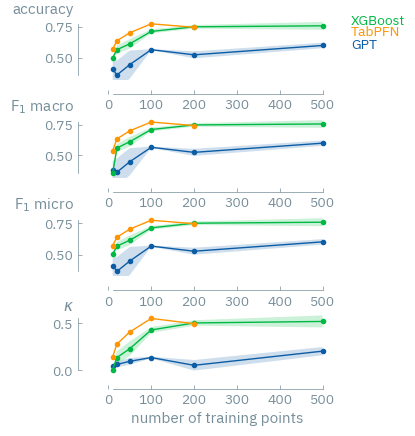

In [14]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

    range_frame(
        ax[i],
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        np.vstack(
            [
                grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric][
                    "mean"
                ].values.reshape(-1, 1),
                grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric][
                    "mean"
                ].values.reshape(-1, 1),
                grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric][
                    "mean"
                ].values.reshape(-1, 1),
            ]
        ).flatten(),
    )

    ax[i].plot(
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)
fig.savefig("logKHCH4-classification_results_binary.pdf", bbox_inches="tight")

In [24]:
find_learning_curve_intersection(
    grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :]["f1_macro"]["mean"].values[1],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :]["f1_macro"]["mean"],
    )[0],
) / 20

0.5167521931003295

In [16]:
find_learning_curve_intersection(
    grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :]["f1_macro"]["mean"],
    )[0],
) / 10

0.5984082264047599

In [26]:
find_learning_curve_intersection(
    grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :]["f1_macro"]["mean"].values[1],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :]["f1_macro"]["mean"],
    )[0],
) / 20

0.4077913456966392

In [18]:
find_learning_curve_intersection(
    grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index.values[:-1],
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :]["f1_macro"][
            "mean"
        ].values[:-1],
    )[0],
) / 10

12.772089250090374

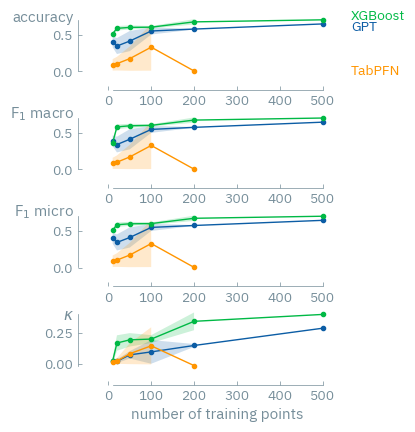

In [19]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        - grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        + grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

    range_frame(
        ax[i],
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        np.vstack(
            [
                grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric][
                    "mean"
                ].values.reshape(-1, 1),
                grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric][
                    "mean"
                ].values.reshape(-1, 1),
                grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric][
                    "mean"
                ].values.reshape(-1, 1),
            ]
        ).flatten(),
    )

    ax[i].plot(
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        - grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        + grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        - grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        + grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)

fig.savefig("logKHCO2-classification_results_binary.pdf", bbox_inches="tight")

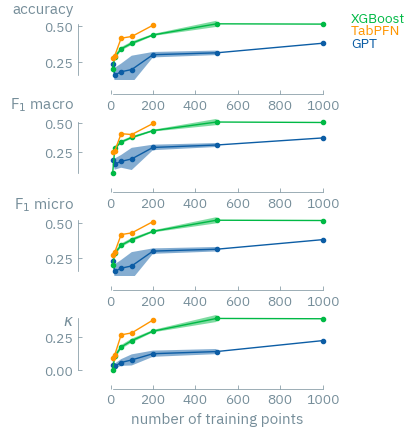

In [20]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.5,
    )
    range_frame(
        ax[i],
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        np.vstack(
            [
                grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric][
                    "mean"
                ].values.reshape(-1, 1),
                grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric][
                    "mean"
                ].values.reshape(-1, 1),
                grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric][
                    "mean"
                ].values.reshape(-1, 1),
            ]
        ).flatten(),
    )

    ax[i].plot(
        grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.5,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.5,
    )

ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)

fig.savefig("logKHCH4-classification_results_5.pdf", bbox_inches="tight")

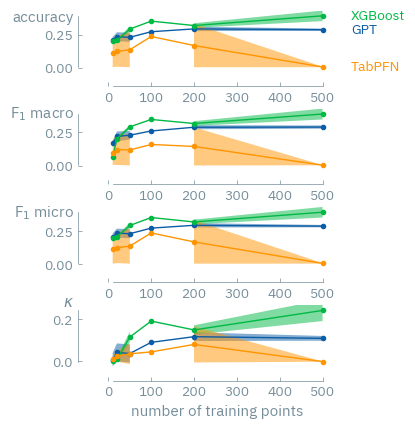

In [21]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        - grouped_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        grouped_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        + grouped_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        alpha=0.5,
    )
    range_frame(
        ax[i],
        grouped_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        np.vstack(
            [
                grouped_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric][
                    "mean"
                ].values.reshape(-1, 1),
                grouped_xgboost_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric][
                    "mean"
                ].values.reshape(-1, 1),
                grouped_tabpfn_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric][
                    "mean"
                ].values.reshape(-1, 1),
            ]
        ).flatten(),
    )

    ax[i].plot(
        grouped_xgboost_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        - grouped_xgboost_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        grouped_xgboost_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        + grouped_xgboost_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        alpha=0.5,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        - grouped_tabpfn_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        grouped_tabpfn_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        + grouped_tabpfn_res.loc[5, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        alpha=0.5,
    )

ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)

fig.savefig("logKHCO2-classification_results_5.pdf", bbox_inches="tight")